In [16]:
import config as config
from pathlib import Path
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from src.dataset.data_reader import DatasetReader
from src.dataset.data_loader import DataLoader

In [17]:
subjetc_id = f'0{1}'
reader = DatasetReader(
            sub_id=subjetc_id
        )
data_loader = DataLoader(
            eeg=reader.eeg,
            audio=reader.audio,
            stimulus=reader.stimulus
        )

eeg_trials = data_loader.eeg_trials
eeg_trials = np.mean(eeg_trials, axis=1)
audio_trials = data_loader.audio_trials
word_trials = data_loader.word_labels

╭──────────────────────────────────╮
│ 🚀 Initializing DatasetReader... │
╰──────────────────────────────────╯

🧑‍⚕️ Loading Data for Subject: 01

📂    Looking for file: sub-01_task-wordProduction

╭────────────────────────╮
│ 📡 Reading NWB Data... │
╰────────────────────────╯

✅ Data successfully loaded!

📂  Preprocessing Audio...

🔄  Downsampling audio...

🎚️  Normalizing audio...

✅  Audio preprocessing complete!

📂  Preprocessing EEG...

╭──────────────────────────────────╮
│ 🚀 Initializing DatasetLoader... │
╰──────────────────────────────────╯

📊 Loading Trials

📊 EEG trails shape: (100, 1024, 127)

🔊 Audio trails shape: (100, 16000)

📝 words Shape: (100,)

In [28]:
eeg_trials.shape

(100, 127)

In [29]:
1024*127

130048

In [19]:
audio_trials[0].shape

(16000,)

In [20]:
import torch
import torchaudio
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import numpy as np

def generate_sine_wave(frequency=440, duration=1.0, sample_rate=16000, amplitude=0.5):
    """
    Generate a sine wave audio sample.
    
    Args:
        frequency (float): Frequency of the sine wave in Hz.
        duration (float): Duration of the audio sample in seconds.
        sample_rate (int): Number of samples per second (Hz).
        amplitude (float): Amplitude of the wave (0 to 1).
    
    Returns:
        np.ndarray: NumPy array representing the audio sample.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    audio = amplitude * np.sin(2 * np.pi * frequency * t)
    return audio

audio_sample = generate_sine_wave()

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

input_values = processor(audio_trials[0], return_tensors="pt", sampling_rate=16000).input_values
print(input_values.shape)
with torch.no_grad():
    outputs = model(input_values)

latent_space = outputs.last_hidden_state

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 16000])


RuntimeError: expected scalar type Double but found Float

In [14]:
latent_space.shape

torch.Size([1, 49, 768])

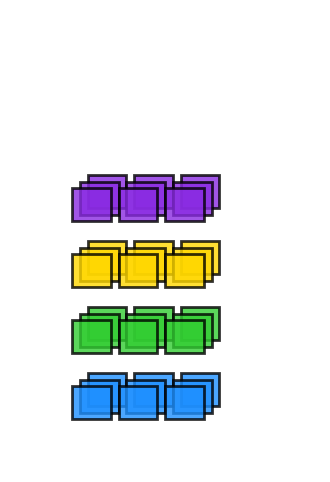

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def draw_block(ax, x, y, width, height, color, depth=3):
    for i in range(depth):
        ax.add_patch(plt.Rectangle((x - i * 0.1, y - i * 0.1), width, height, 
                                   edgecolor='black', facecolor=color, lw=2, alpha=0.8))

def draw_stacked_blocks():
    fig, ax = plt.subplots(figsize=(4, 6))
    ax.set_xlim(-1, 3)
    ax.set_ylim(-1, 6)
    ax.axis('off')
    
    colors = ['#1E90FF', '#32CD32', '#FFD700', '#8A2BE2']  # Beautiful color palette
    
    for i in range(4):
        for j in range(3):
            draw_block(ax, j * 0.6, i, 0.5, 0.5, colors[i])
    
    plt.savefig('block.png', dpi=600)

draw_stacked_blocks()


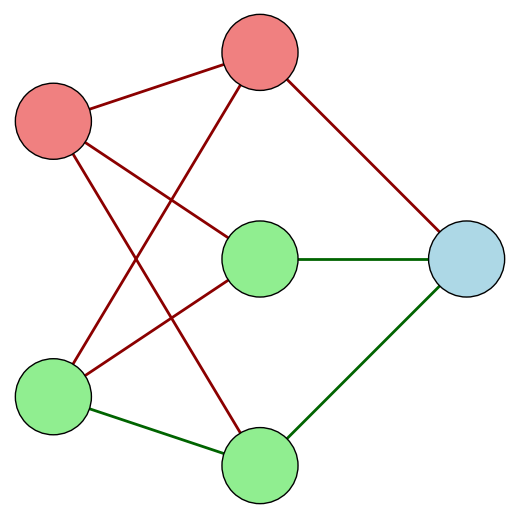

In [27]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_neural_network():
    G = nx.Graph()
    
    # Define node positions
    positions = {
        'input1': (-1, 1), 'input2': (-1, -1),
        'hidden1': (0, 1.5), 'hidden2': (0, 0), 'hidden3': (0, -1.5),
        'output': (1, 0)
    }
    
    # Define edges
    edges = [
        ('input1', 'hidden1'), ('input1', 'hidden2'), ('input1', 'hidden3'),
        ('input2', 'hidden1'), ('input2', 'hidden2'), ('input2', 'hidden3'),
        ('hidden1', 'output'), ('hidden2', 'output'), ('hidden3', 'output')
    ]
    
    G.add_edges_from(edges)
    
    # Define colors for nodes and edges
    node_colors = ['lightcoral', 'lightcoral', 'lightgreen', 'lightgreen', 'lightgreen', 'lightblue']
    edge_colors = ['darkred', 'darkred', 'darkred', 'darkred', 'darkred', 'darkred', 'darkgreen', 'darkgreen', 'darkgreen']
    
    # Draw the nodes without text labels
    plt.figure(figsize=(5, 5), facecolor='#F0F8FF')  # Alice blue background
    nx.draw(G, positions, with_labels=False, node_size=3000, node_color=node_colors, 
            edge_color=edge_colors, width=2, font_size=10, font_weight='bold', 
            edgecolors='black')
    
    plt.savefig('gpt2.png', dpi=800)

draw_neural_network()


In [30]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import config

In [73]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import config

def plot_r2(model):
    destination_dir = Path(config.CUR_DIR, 'Results', 'Images')
    root_dir = config.TRAINED_DIR
    subject_r2_scores = {}

    for subject in sorted(os.listdir(root_dir)):
        subject_path = os.path.join(root_dir, subject, "Mapping", model)
        if os.path.exists(subject_path):
            r2_scores = []
            for fold_file in sorted(os.listdir(subject_path)):
                if fold_file.endswith(".npy"):
                    fold_path = os.path.join(subject_path, fold_file)
                    values = np.load(fold_path) 
                    r2_scores.append(values[2])  # Extract R² score
            
            if r2_scores:
                subject_r2_scores[subject] = r2_scores

    # Calculate mean R² for each subject
    subject_means = {subject: np.mean(scores) for subject, scores in subject_r2_scores.items()}

    # Print or return the means
    print("Mean R² scores for each subject:")
    for subject, mean_score in subject_means.items():
        print(f"{subject}: {mean_score:.4f}")

    # Convert data into a DataFrame
    subjects = []
    scores = []
    
    for subject, r2_values in subject_r2_scores.items():
        subjects.extend([subject] * len(r2_values))
        scores.extend(r2_values)

    data = pd.DataFrame({"Subjects": subjects, "R²": scores})

    # Plotting
    sns.set_style("whitegrid")

    plt.figure(figsize=(14, 7))

    # Box plot (Only for quartiles and mean)
    ax = sns.boxplot(data=data, x="Subjects", y="R²", palette="coolwarm", showmeans=True, 
                     meanprops={"marker": "s", "markerfacecolor": "red", "markeredgecolor": "black", "markersize": 10})

    # Swarm plot (Properly aligned with `dodge=True`)
    sns.stripplot(data=data, x="Subjects", y="R²", color=".25", size=6, alpha=0.7, jitter=True, dodge=True)

    # Customize fonts and colors
    plt.xlabel("Subjects", fontsize=20, fontweight="bold", color="#003366")  
    plt.ylabel("R²", fontsize=20, fontweight="bold", color="#003366")  

    # Change tick font size and color
    plt.xticks(rotation=45, fontsize=18,fontweight="bold",color="black")  
    plt.yticks(fontsize=18,fontweight="bold",  color="black")  

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Save plot
    os.makedirs(destination_dir, exist_ok=True)
    filename = Path(destination_dir, f'{model}.pdf')
    plt.savefig(filename, dpi=800, format='pdf', bbox_inches="tight")

    plt.show()  # Display the plot

    return subject_means  # Return the means if needed



Mean R² scores for each subject:
01: 0.8724
02: 0.9446
03: 0.8816
04: 0.9909
05: 0.7965
06: 0.9122
07: 0.5928
08: 0.8744
09: 0.5336


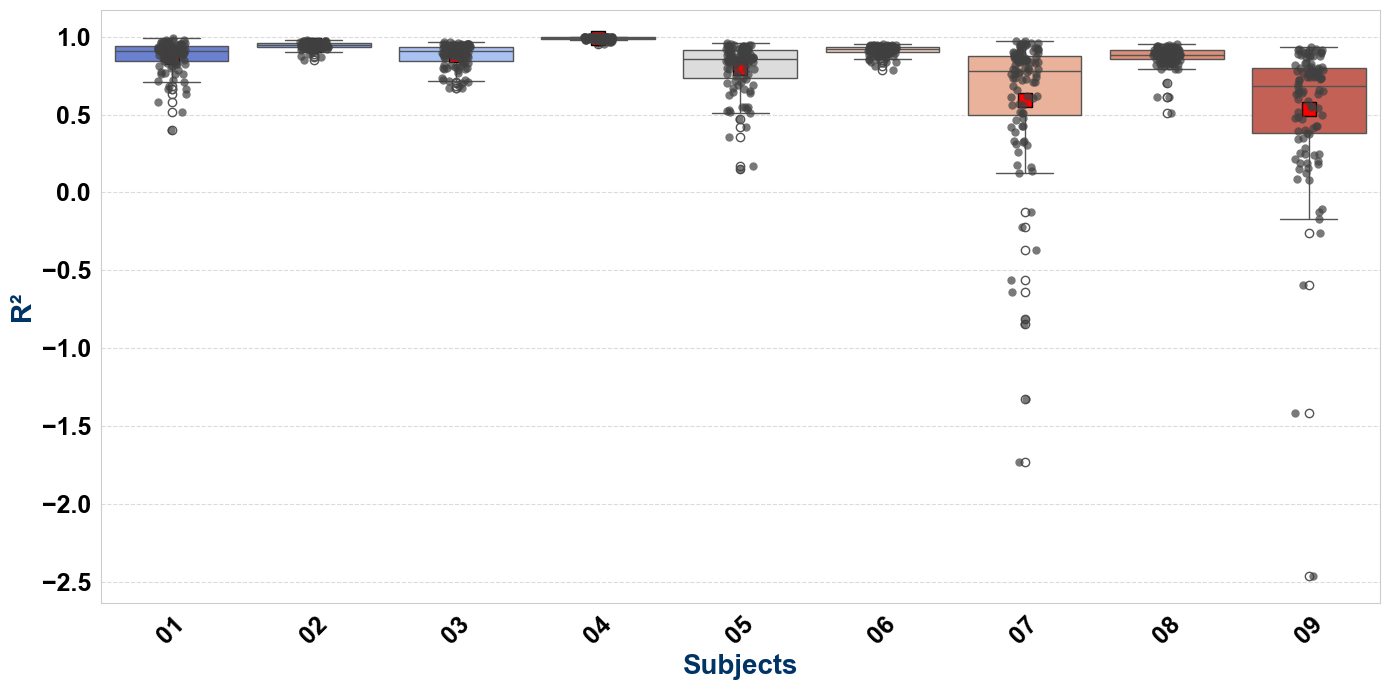

Mean R² scores for each subject:
01: 0.8733
02: 0.9446
03: 0.8814
04: 0.9908
05: 0.7960
06: 0.9125
07: 0.6049
08: 0.8747
09: 0.5351


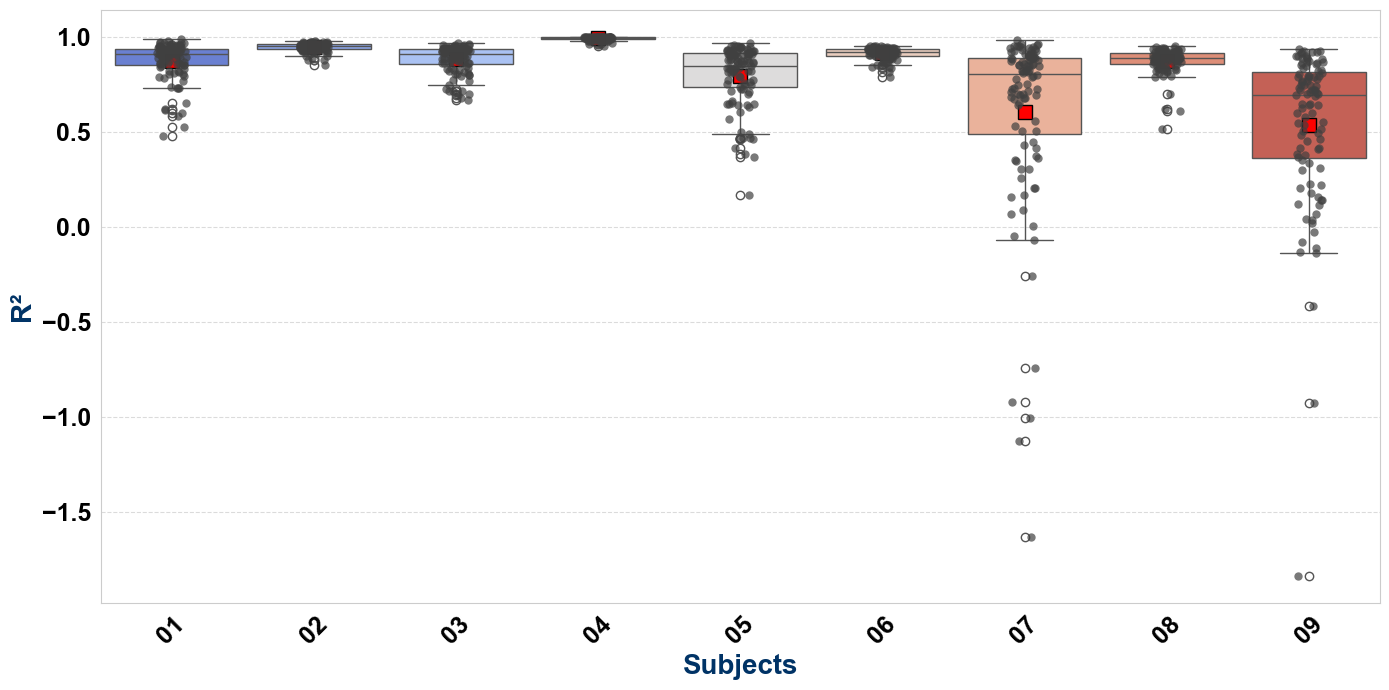

In [75]:

chat = plot_r2(model='ElasticNet_ChatGPT')
fast = plot_r2(model='ElasticNet_FastText')

In [58]:
chat

{'01': 0.8724011191291904,
 '02': 0.9445725995063136,
 '03': 0.8815942145635793,
 '04': 0.9908688409444215,
 '05': 0.7965176752037831,
 '06': 0.9121691839186024,
 '07': 0.5927679432021312,
 '08': 0.8744189483411341,
 '09': 0.5335783192553635}

In [59]:
fast

{'01': 0.8733013799562169,
 '02': 0.9446044155783362,
 '03': 0.8814435979456141,
 '04': 0.990820783092649,
 '05': 0.7959768239945089,
 '06': 0.9125422589117406,
 '07': 0.6048539666789303,
 '08': 0.8747020610588955,
 '09': 0.5350557535536657}

In [124]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import config

def plot_r2_vs_trials_all_subjects_in_bins(model):
    root_dir = config.TRAINED_DIR
    destination_dir = Path(config.CUR_DIR, 'Results', 'Images')

    plt.figure(figsize=(12, 6))

    # Get color cycle from Matplotlib
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_index = 0  # Track index for cycling through colors

    # Dictionary to track occupied y-positions in each bin to prevent text overlap
    occupied_positions = {}

    # Loop through subjects and plot on the same figure
    for subject in sorted(os.listdir(root_dir)):
        subject_path = os.path.join(root_dir, subject, "Mapping", model)
        all_r2_scores = []

        if os.path.exists(subject_path):
            for fold_file in sorted(os.listdir(subject_path)):
                if fold_file.endswith(".npy"):
                    fold_path = os.path.join(subject_path, fold_file)
                    values = np.load(fold_path)
                    r2_value = values[2]  # Extract R² score
                    all_r2_scores.append(r2_value)

        if not all_r2_scores:
            print(f"No R² scores found for subject {subject}.")
            continue

        # Create bins from 0 to 1 with a 0.1 step
        bins = np.arange(0, 1.1, 0.05)

        # Count occurrences of each R² score in the bins
        binned_data = pd.cut(all_r2_scores, bins=bins)
        trial_counts = pd.value_counts(binned_data, sort=False)

        # Get color from cycle
        line_color = color_cycle[color_index % len(color_cycle)]
        color_index += 1  # Increment color index for next subject

        # Line plot for each subject
        plt.plot(trial_counts.index.astype(str), trial_counts.values, marker='o', linestyle='--', 
                 label=f"Subject {subject}", color=line_color)

        # Annotate each point with the number of trials (excluding zeros)
        for i, (bin_label, count) in enumerate(zip(trial_counts.index.astype(str), trial_counts.values)):
            if count > 0:  # Only annotate non-zero values
                # Determine an available y-position to avoid overlap
                y_position = count
                while (i, y_position) in occupied_positions:  # Shift up if space is occupied
                    y_position += 3

                # Mark this position as occupied
                occupied_positions[(i, y_position)] = True

                #plt.text(i, y_position, str(count), fontsize=12, ha='center', va='bottom', 
                        # color=line_color, fontweight='bold')

    # Plot labels and title
    plt.xlabel("R²", fontsize=18, fontweight="bold", color="#003366")
    plt.ylabel("# Trials", fontsize=18, fontweight="bold", color="#003366")

    plt.xticks(rotation=45, fontsize=18,fontweight="bold",color="black")  
    plt.yticks(fontsize=18,fontweight="bold",  color="black")  

    # Add legend to distinguish subjects
    plt.legend(title="Subjects", fontsize=12, title_fontsize=14)

    plt.tight_layout()

    # Save plot
    os.makedirs(destination_dir, exist_ok=True)
    filename = Path(destination_dir, f'{model}_r2_vs_#trials.pdf')
    plt.savefig(filename, dpi=800, format='pdf', bbox_inches="tight")

    plt.show()


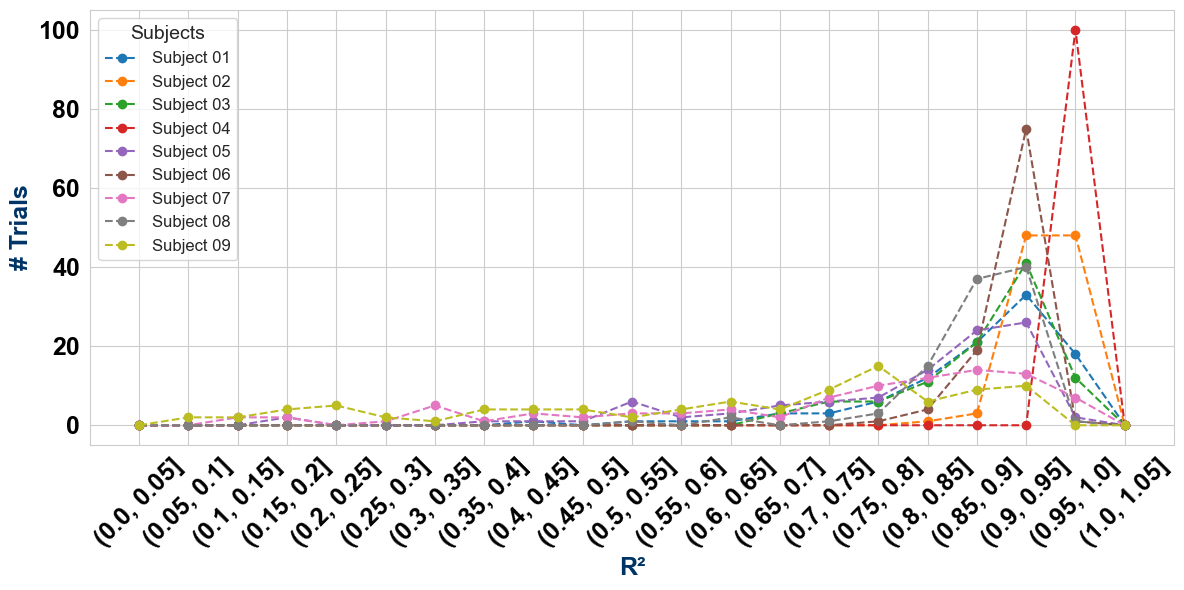

In [125]:
plot_r2_vs_trials_all_subjects_in_bins(model='ElasticNet_ChatGPT')

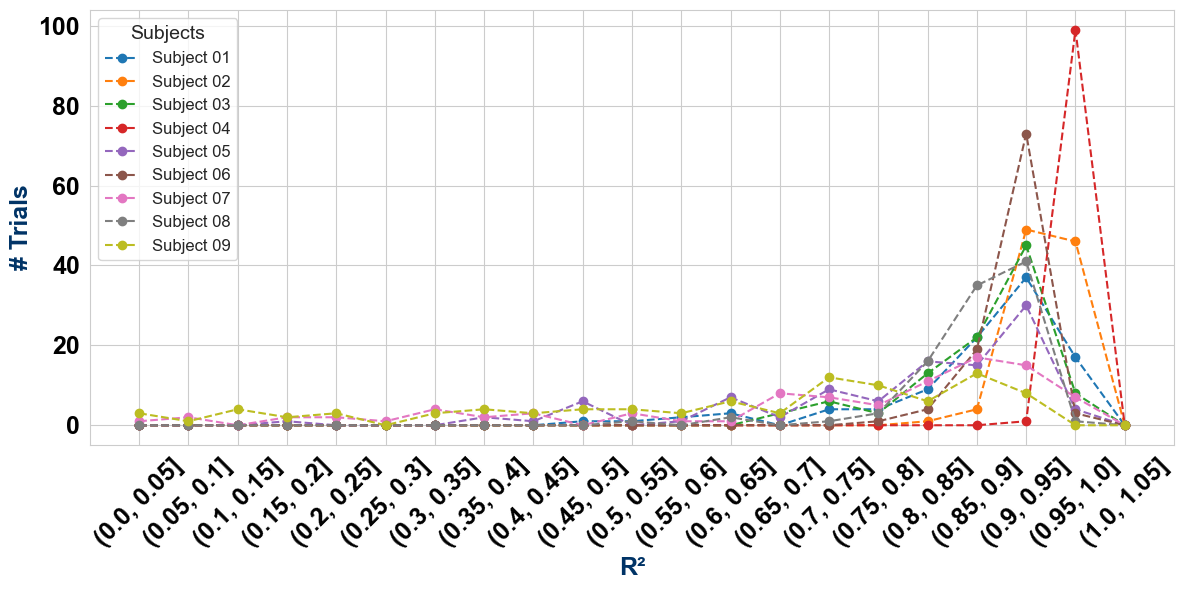

In [126]:
plot_r2_vs_trials_all_subjects_in_bins(model='ElasticNet_FastText')

In [146]:
def count_trials_by_r2_range(r2_values):
    bins = np.arange(0, 1.1, 0.1)
    counts, _ = np.histogram(r2_values, bins=bins)
    r2_ranges = {f"{bins[i]:.1f} - {bins[i+1]:.1f}": counts[i] for i in range(len(counts))}
    
    return r2_ranges

In [ ]:
def plot_avg_trials_across_subjects(model):
    root_dir = config.TRAINED_DIR
    destination_dir = Path(config.CUR_DIR, 'Results', 'Images')

   
    range_scores = []
    for subject in sorted(os.listdir(root_dir)):
        subject_path = os.path.join(root_dir, subject, "Mapping", model)
        all_r2_scores = []

        if os.path.exists(subject_path):
            for fold_file in sorted(os.listdir(subject_path)):
                if fold_file.endswith(".npy"):
                    fold_path = os.path.join(subject_path, fold_file)
                    values = np.load(fold_path)
                    r2_value = values[2]  # Extract R² score
                    all_r2_scores.append(r2_value)
       
        r2_range = count_trials_by_r2_range(all_r2_scores)
        range_scores.append(r2_range)
    
    

def find_average_across_all()



In [145]:
plot_avg_trials_across_subjects(model='ElasticNet_ChatGPT')

{'0.0 - 0.1': 0, '0.1 - 0.2': 0, '0.2 - 0.3': 0, '0.3 - 0.4': 0, '0.4 - 0.5': 1, '0.5 - 0.6': 2, '0.6 - 0.7': 4, '0.7 - 0.8': 9, '0.8 - 0.9': 33, '0.9 - 1.0': 51}
{'0.0 - 0.1': 0, '0.1 - 0.2': 0, '0.2 - 0.3': 0, '0.3 - 0.4': 0, '0.4 - 0.5': 0, '0.5 - 0.6': 0, '0.6 - 0.7': 0, '0.7 - 0.8': 0, '0.8 - 0.9': 4, '0.9 - 1.0': 96}
{'0.0 - 0.1': 0, '0.1 - 0.2': 0, '0.2 - 0.3': 0, '0.3 - 0.4': 0, '0.4 - 0.5': 0, '0.5 - 0.6': 0, '0.6 - 0.7': 3, '0.7 - 0.8': 12, '0.8 - 0.9': 32, '0.9 - 1.0': 53}
{'0.0 - 0.1': 0, '0.1 - 0.2': 0, '0.2 - 0.3': 0, '0.3 - 0.4': 0, '0.4 - 0.5': 0, '0.5 - 0.6': 0, '0.6 - 0.7': 0, '0.7 - 0.8': 0, '0.8 - 0.9': 0, '0.9 - 1.0': 100}
{'0.0 - 0.1': 0, '0.1 - 0.2': 2, '0.2 - 0.3': 0, '0.3 - 0.4': 1, '0.4 - 0.5': 2, '0.5 - 0.6': 8, '0.6 - 0.7': 8, '0.7 - 0.8': 13, '0.8 - 0.9': 38, '0.9 - 1.0': 28}
{'0.0 - 0.1': 0, '0.1 - 0.2': 0, '0.2 - 0.3': 0, '0.3 - 0.4': 0, '0.4 - 0.5': 0, '0.5 - 0.6': 0, '0.6 - 0.7': 0, '0.7 - 0.8': 1, '0.8 - 0.9': 23, '0.9 - 1.0': 76}
{'0.0 - 0.1': 0, '0.1